# 1: Import các thư viện

In [ ]:
import pandas as pd # Đọc dữ liệu
import numpy as np # Xử lý dữ liệu
import matplotlib.pyplot as plt # Vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler # Chuẩn hóa dữ liệu
from keras.callbacks import EarlyStopping, ModelCheckpoint # Lưu lại mô hình huấn luyện tốt nhất
from tensorflow.keras.models import load_model # Tải mô hình

# Các lớp để xây dựng mô hình
from keras.models import Sequential # Đầu vào
from keras.layers import LSTM # Học phụ thuộc
from keras.layers import Dropout # Tránh học tủ
from keras.layers import Dense # Đầu ra

# Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score # Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error # Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error # Đo % sai số tuyệt đối trung bình

# 2: Đọc dữ liệu

In [ ]:
# Cấp quyền truy cập google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Đọc dữ liệu từ file csv
df = pd.read_csv('/content/drive/MyDrive/dataset/VIC.csv')

# Drop dòng "Open Interest" không dùng đến trong dataset
df = df.drop(columns=["Open Interest"])

# Hiển thị lại DataFrame sau khi xóa
print(df)

       Ticker         Date/Time   Open   High    Low  Close  Volume
0         VIC   10/17/2018 9:39   98.5   98.5   98.5   98.5     390
1         VIC   10/17/2018 9:40   98.5   98.5   98.5   98.5     760
2         VIC   10/17/2018 9:41   98.6   98.6   98.6   98.6    2060
3         VIC   10/17/2018 9:42   98.6   98.6   98.6   98.6    5540
4         VIC   10/17/2018 9:43   98.6   98.7   98.6   98.7     760
...       ...               ...    ...    ...    ...    ...     ...
101261    VIC  12/22/2020 14:22  105.8  105.8  105.7  105.7    1870
101262    VIC  12/22/2020 14:23  105.7  105.7  105.7  105.7    2510
101263    VIC  12/22/2020 14:24  105.7  105.7  105.7  105.7    3620
101264    VIC  12/22/2020 14:25  105.7  105.7  105.7  105.7     100
101265    VIC  12/22/2020 14:46  105.7  105.7  105.7  105.7      90

[101266 rows x 7 columns]


# 3: Mô tả dữ liệu

In [ ]:
# Định dạng cấu trúc thời gian
df["Date/Time"] = pd.to_datetime(df["Date/Time"], format="%m/%d/%Y %H:%M")

In [ ]:
# Kích thước dữ liệu
df.shape

(101266, 7)

In [ ]:
# Dữ liệu 5 dòng đầu
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume
0,VIC,2018-10-17 09:39:00,98.5,98.5,98.5,98.5,390
1,VIC,2018-10-17 09:40:00,98.5,98.5,98.5,98.5,760
2,VIC,2018-10-17 09:41:00,98.6,98.6,98.6,98.6,2060
3,VIC,2018-10-17 09:42:00,98.6,98.6,98.6,98.6,5540
4,VIC,2018-10-17 09:43:00,98.6,98.7,98.6,98.7,760


In [ ]:
# Xác định kiểu dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101266 entries, 0 to 101265
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Ticker     101266 non-null  object        
 1   Date/Time  101266 non-null  datetime64[ns]
 2   Open       101266 non-null  float64       
 3   High       101266 non-null  float64       
 4   Low        101266 non-null  float64       
 5   Close      101266 non-null  float64       
 6   Volume     101266 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.4+ MB


In [ ]:
# Mô tả bộ dữ liệu
df.describe()

,Date/Time,Open,High,Low,Close,Volume
count,101266,101266.000000,101266.000000,101266.000000,101266.000000,1.012660e+05
mean,2019-12-05 15:50:51.577627392,105.376460,105.418519,105.334147,105.378791,3.182640e+03
min,2018-10-17 09:39:00,68.000000,68.000000,68.000000,68.000000,1.000000e+01
25%,2019-05-16 13:29:15,95.400000,95.400000,95.300000,95.400000,2.300000e+02
50%,2019-12-13 11:09:30,105.300000,105.300000,105.200000,105.300000,1.020000e+03
75%,2020-06-25 10:28:45,115.800000,115.900000,115.800000,115.800000,3.000000e+03
max,2020-12-22 14:46:00,126.100000,126.500000,126.100000,126.500000,1.468390e+06
std,NaN,11.543158,11.535584,11.552338,11.545054,1.469814e+04


# 4: Tiền xử lý dữ liệu

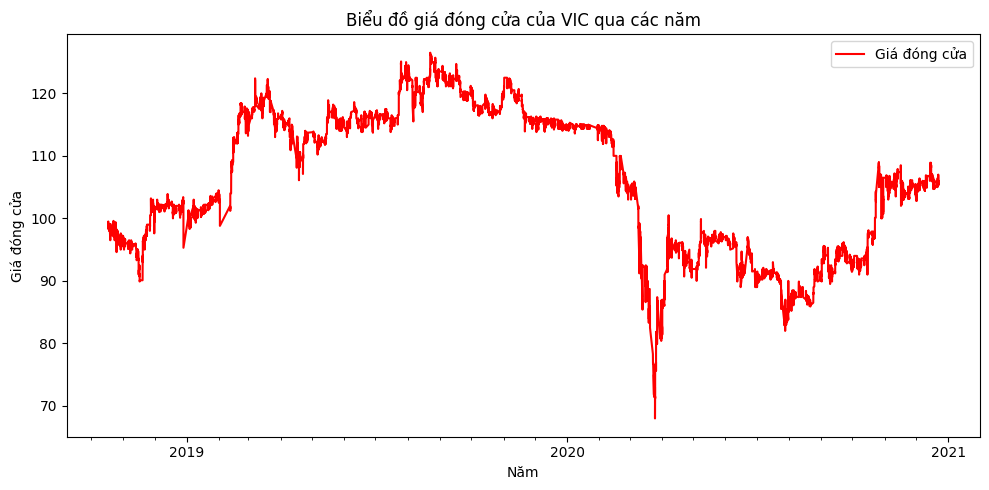

In [ ]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator # Thêm MonthLocator vào để sửa lỗi
# Chuyển đổi cột "Date/Time" sang dạng datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d/%m/%Y')

# Sắp xếp lại dữ liệu theo thứ tự thời gian
df = df.sort_values(by='Date/Time')

# Chuyển đổi định dạng các cột giá thành số thực
df['Close'] = df['Close'].astype(float)
df['Open'] = df['Open'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)

# Lấy thông tin năm từ cột "Date/Time"
df['Year'] = df['Date/Time'].dt.year

# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Date/Time'], df['Close'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của VIC qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout() # Loại bỏ các giá trị trùng lặp
plt.show()

In [ ]:
df1 = pd.DataFrame(df,columns=['Date/Time','Close'])
df1.index = df1['Date/Time']
df1.drop('Date/Time', axis=1, inplace=True)
df1

,Close
Date/Time,
2018-10-17 09:39:00,98.5
2018-10-17 09:40:00,98.5
2018-10-17 09:41:00,98.6
2018-10-17 09:42:00,98.6
2018-10-17 09:43:00,98.7
...,...
2020-12-22 14:22:00,105.7
2020-12-22 14:23:00,105.7
2020-12-22 14:24:00,105.7


In [ ]:
# Chia tập dữ liệu: 80% để huấn luyện mô hình và 20% dùng để test
data = df1.values
num_rows = len(data)
train_size = int(0.8 * num_rows)

train_data = data[:train_size]
test_data = data[train_size:]

In [ ]:
data

array([[ 98.5],
       [ 98.5],
       [ 98.6],
       ...,
       [105.7],
       [105.7],
       [105.7]])

In [ ]:
# Chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

In [ ]:
# Tạo vòng lặp các giá trị
x_train, y_train=[], []
for i in range(60, len(train_data)):
  x_train.append(sc_train[i-60:i, 0]) # Lấy 60 giá đóng cửa liên tục
  y_train.append(sc_train[i, 0]) # Lấy ra giá đóng cửa ngày hôm sau

In [ ]:
x_train

[array([0.52136752, 0.52136752, 0.52307692, 0.52307692, 0.52478632,
        0.52478632, 0.52649573, 0.52478632, 0.52649573, 0.52649573,
        0.52478632, 0.52307692, 0.52307692, 0.52307692, 0.52136752,
        0.52307692, 0.52478632, 0.52478632, 0.52991453, 0.52649573,
        0.52991453, 0.53333333, 0.53846154, 0.52649573, 0.52820513,
        0.52820513, 0.53846154, 0.52991453, 0.52991453, 0.52991453,
        0.53162393, 0.53504274, 0.53675214, 0.53333333, 0.53333333,
        0.53333333, 0.53333333, 0.52991453, 0.52991453, 0.52991453,
        0.52991453, 0.52820513, 0.52649573, 0.52478632, 0.52478632,
        0.52478632, 0.52478632, 0.52478632, 0.52478632, 0.52478632,
        0.52649573, 0.52649573, 0.52307692, 0.52307692, 0.52307692,
        0.52307692, 0.52307692, 0.52307692, 0.52307692, 0.52478632]),
 array([0.52136752, 0.52307692, 0.52307692, 0.52478632, 0.52478632,
        0.52649573, 0.52478632, 0.52649573, 0.52649573, 0.52478632,
        0.52307692, 0.52307692, 0.52307692, 0.

In [ ]:
y_train

[0.5247863247863249,
 0.5247863247863249,
 0.523076923076923,
 0.5213675213675215,
 0.5213675213675215,
 0.5213675213675215,
 0.5213675213675215,
 0.523076923076923,
 0.5213675213675215,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.5213675213675215,
 0.5179487179487179,
 0.5213675213675215,
 0.5213675213675215,
 0.5213675213675215,
 0.5179487179487179,
 0.5213675213675215,
 0.5179487179487179,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.5247863247863249,
 0.523076923076923,
 0.523076923076923,
 0.5213675213675215,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.5247863247863249,
 0.523076923076923,
 0.5247863247863249,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.523076923076923,
 0.5213675213675215,
 0.5213675213675215,
 0.5213675213675215,
 0.523076923076923,
 0.523076923076923,
 0.5213675213675215,
 0.523076923076923,
 0.52136752136752

In [ ]:
# Xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

# Xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

# 5: Xây dựng và huấn luyện mô hình

## 5.1: Xây dựng

In [ ]:
# Xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào

# 2 lớp LSTM
model.add(LSTM(units=128, input_shape=(x_train.shape[1], 1), return_sequences=True))
model.add(LSTM(units=64))
model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
model.add(Dense(1)) #output đầu ra 1 chiều
# Đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error', optimizer='adam')

## 5.2: Huấn luyện

In [ ]:
# Huấn luyện mô hình
save_model = "/content/drive/MyDrive/dataset/VIC_save_model.keras"
best_model = ModelCheckpoint(save_model, monitor='loss', verbose=2, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='loss', patience=10) # Ngừng huấn luyện nếu như mô hình không còn cải thiện sau 10 epochs
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=2, callbacks=[best_model, early_stopping])

Epoch 1/100

Epoch 1: loss improved from inf to 0.05427, saving model to /content/drive/MyDrive/dataset/VIC_save_model.keras
1265/1265 - 207s - loss: 0.0543 - 207s/epoch - 164ms/step
Epoch 2/100

Epoch 2: loss improved from 0.05427 to 0.02426, saving model to /content/drive/MyDrive/dataset/VIC_save_model.keras
1265/1265 - 203s - loss: 0.0243 - 203s/epoch - 161ms/step
Epoch 3/100

Epoch 3: loss improved from 0.02426 to 0.02011, saving model to /content/drive/MyDrive/dataset/VIC_save_model.keras
1265/1265 - 204s - loss: 0.0201 - 204s/epoch - 162ms/step
Epoch 4/100

Epoch 4: loss improved from 0.02011 to 0.01924, saving model to /content/drive/MyDrive/dataset/VIC_save_model.keras
1265/1265 - 207s - loss: 0.0192 - 207s/epoch - 163ms/step
Epoch 5/100

Epoch 5: loss improved from 0.01924 to 0.01910, saving model to /content/drive/MyDrive/dataset/VIC_save_model.keras
1265/1265 - 209s - loss: 0.0191 - 209s/epoch - 165ms/step
Epoch 6/100

Epoch 6: loss improved from 0.01910 to 0.01889, saving m

In [ ]:
# Dữ liệu train
y_train = sc.inverse_transform(y_train) # Giá thực
final_model = load_model("/content/drive/MyDrive/dataset/VIC_save_model.keras")
y_train_predict = final_model.predict(x_train) # Dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) # Giá dự đoán

2530/2530 [==============================] - 107s 42ms/step


# 6: Sử dụng mô hình

In [ ]:
# Xử lý dữ liệu test
test = df1[len(train_data)-60:].values
test = test.reshape(-1, 1)
sc_test = sc.transform(test)

x_test = []
for i in range(60, test.shape[0]):
  x_test.append(sc_test[i-60:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Dữ liệu test
y_test = data[train_size:] # Giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) # Giá dự đoán

633/633 [==============================] - 27s 43ms/step


# Độ chính xác của mô hình

<ipython-input-22-df492ed38fce>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data1['Dự đoán'] = y_train_predict # Thêm dữ liệu
<ipython-input-22-df492ed38fce>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data1['Dự đoán'] = y_test_predict # Thêm dữ liệu


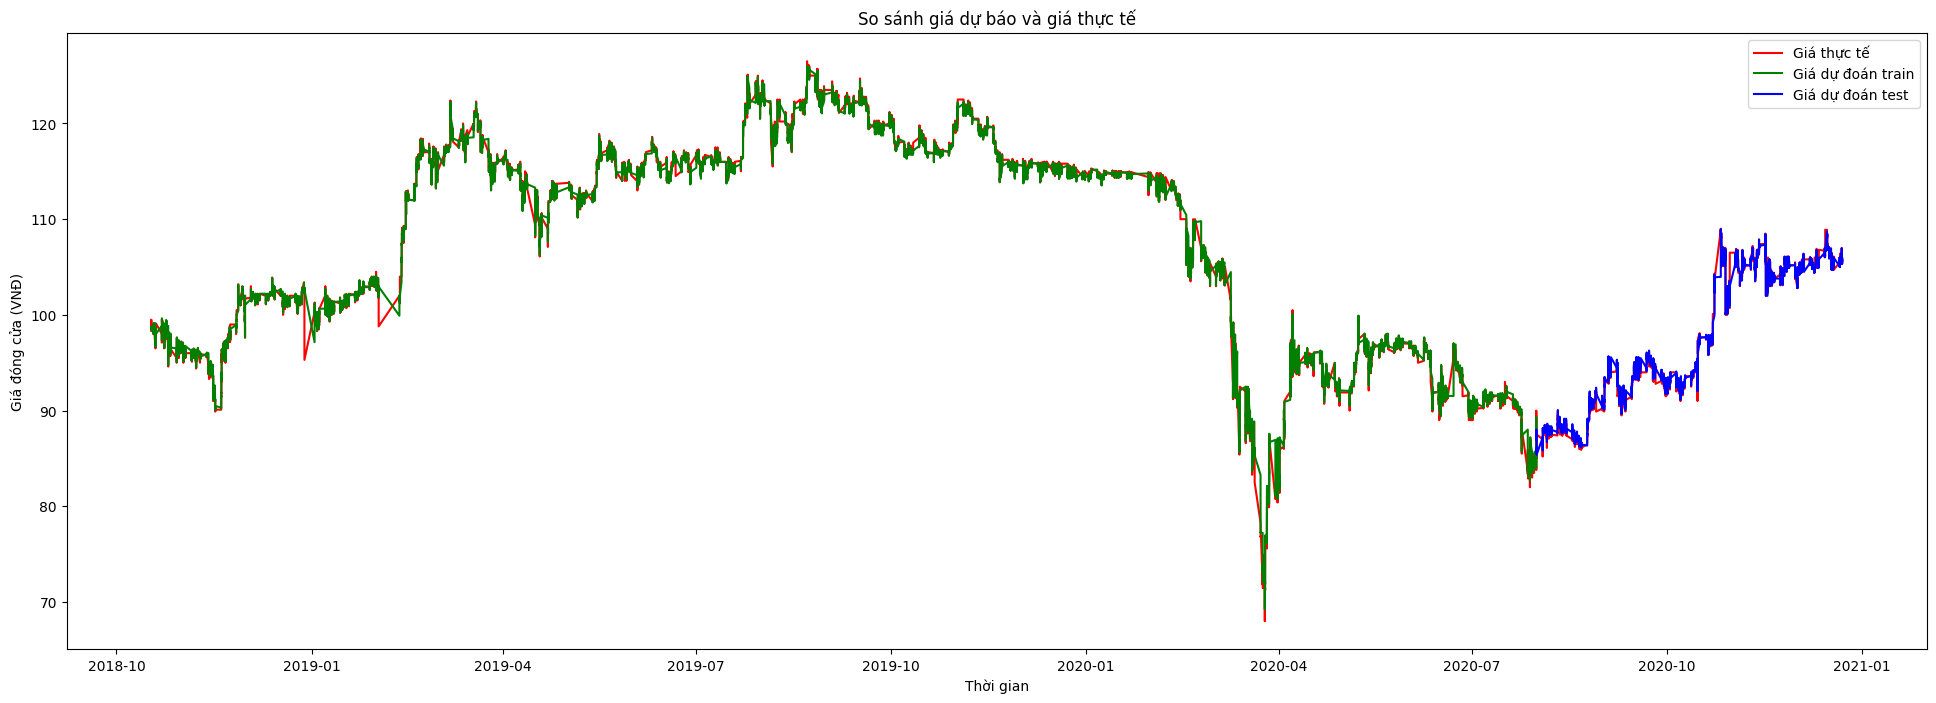

In [ ]:
# Lập biểu đồ so sánh
train_data1 = df1[60:train_size]
test_data1 = df1[train_size:]

plt.figure(figsize=(24, 8))
plt.plot(df1,label='Giá thực tế', color='red') # Đường giá thực
train_data1['Dự đoán'] = y_train_predict # Thêm dữ liệu
plt.plot(train_data1['Dự đoán'], label='Giá dự đoán train', color='green') # Đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict # Thêm dữ liệu
plt.plot(test_data1['Dự đoán'], label='Giá dự đoán test', color='blue') # Đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') # Đặt tên biểu đồ
plt.xlabel('Thời gian') # Đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') # Đặt tên hàm y
plt.legend() # Chú thích
plt.show()

In [ ]:
#r2
print('Độ phù hợp tập train:', r2_score(y_train, y_train_predict))

#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):', mean_absolute_error(y_train, y_train_predict))

#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:', mean_absolute_percentage_error(y_train, y_train_predict))

Độ phù hợp tập train: 0.9996400934001193
Sai số tuyệt đối trung bình trên tập train (VNĐ): 0.14412570404480995
Phần trăm sai số tuyệt đối trung bình tập train: 0.001390545202895728


In [ ]:
train_data1

,Close,Dự đoán
Date/Time,,
2018-10-17 10:49:00,98.7,98.717789
2018-10-17 10:50:00,98.7,98.741768
2018-10-17 10:53:00,98.6,98.745262
2018-10-17 10:54:00,98.5,98.670578
2018-10-17 10:55:00,98.5,98.572281
...,...,...
2020-07-31 10:02:00,86.7,87.044373
2020-07-31 10:03:00,86.7,86.938782
2020-07-31 10:04:00,87.0,86.907066


In [ ]:
#r2
print('Độ phù hợp tập test:', r2_score(y_test, y_test_predict))

#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):', mean_absolute_error(y_test, y_test_predict))

#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:', mean_absolute_percentage_error(y_test, y_test_predict))

Độ phù hợp tập test: 0.9990638229710557
Sai số tuyệt đối trung bình trên tập test (VNĐ): 0.14189429212984364
Phần trăm sai số tuyệt đối trung bình tập test: 0.0014908950359437147


In [ ]:
test_data1

,Close,Dự đoán
Date/Time,,
2020-07-31 10:08:00,86.8,87.212288
2020-07-31 10:09:00,86.8,87.053703
2020-07-31 10:10:00,86.8,87.010223
2020-07-31 10:11:00,86.8,87.001732
2020-07-31 10:12:00,86.7,87.005081
...,...,...
2020-12-22 14:22:00,105.7,105.779160
2020-12-22 14:23:00,105.7,105.708366
2020-12-22 14:24:00,105.7,105.682663


# Dự đoán biến động giá cổ phiếu

1/1 [==============================] - 1s 1s/step


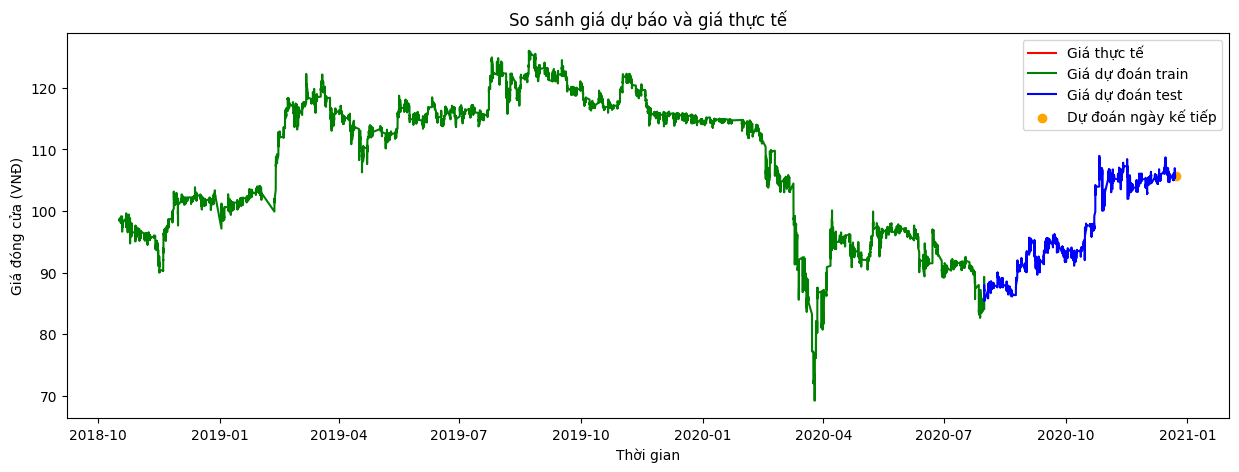

In [ ]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Date/Time'].iloc[-1] + pd.Timedelta(days=1)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Close'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = sc.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([sc_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = sc.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Date/Time': [next_date], 'Close': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Date/Time'], df1['Close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('Giá dự báo')
plt.legend()
plt.show()

In [ ]:
# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
actual_closing_price = df['Close'].iloc[-1]

# Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
comparison_df = pd.DataFrame({'Date/Time': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# In ra bảng so sánh
print(comparison_df)

# Biến động giá cổ phiếu = Giá cổ phiếu N phút sau - Giá cổ phiếu hiện tại
stock_price_fluctuations = y_next_predict[0][0] - actual_closing_price
print("Biến động giá cổ phiếu:", stock_price_fluctuations)

            Date/Time  Giá dự đoán  Giá ngày trước
0 2020-12-23 14:46:00   105.679779           105.7
Biến động giá cổ phiếu: -0.020220947265627842
